In [48]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/rg/vtjd9wkj6cq1lck908ywby500000gn/T/ipykernel_58296/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [49]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


## Project 1. Due by Thursday, February 13. ##

For this project we will use the **London Underground Data**.

1. Compute a Minimum Spanning Tree using, as costs, the straight-line distances of the provided connections, i.e., length of connections computed using the latitude and longitude of each node.

2. Repeat this computation, now using the length of connections provided in the data.

3. Using version 2 of the lengths, we will investigate the robustness of the computation.  We conduct 10000 experiments.  In each experiment the length of each connection is adjusted as follows:
        modified length = max{ (true length)*(1 + Gaussian(0,0.3)), 0.01*(true length) }
i.e., we modify the length randomly using a zero-norm Gaussian distribution with standard deviation 0.3 and correct if the length becomes too small.

  Plot the distribution of minimum spanning tree lengths, as well as the Value-At-Risk at level 5%.

4. Returning to the lengths as in version 2, conduct a delete-and-repair analysis.  That is to say, for each link L of the minimum spanning tree, we

    (a) Remove L from the network.
    
    (b) Compute a minimum spanning tree for the network with L (and only L) removed.  

  Plot the resulting values for the length of the minimum spanning tree.

Note: we only remove one link at a time.



### IMPORTANT ###
1. Please do not submit data.  If you need to generate additional data, submit the code for that as well.
2. By the due date for the project, please make an appointment with the TAs/CAs.  

### Loading Data
Each csv file was loaded into a Pandas dataframe

In [50]:
# Load data into Pandas Dataframes
connections = pd.read_csv(".././London Underground/connections.csv", index_col=0)
lines = pd.read_csv(".././London Underground/lines.csv")
stations = pd.read_csv(".././London Underground/stations.csv")

In [51]:
connections

,station1,station2,line,time,distance(miles)
0,11,163,1,1.0,0.257855
1,11,212,1,2.0,0.454449
2,49,87,1,1.0,0.111148
3,49,197,1,2.0,0.426744
4,82,163,1,2.0,0.273407
...,...,...,...,...,...
428,326,327,14,NaN,6.740020
429,327,328,14,NaN,4.810656
430,319,330,14,NaN,2.606461
431,330,331,14,NaN,NaN


In [52]:
stations

,Unnamed: 0,latitude,longitude,name,zone,total_lines,rail
0,1,51.502800,-0.280100,Acton Town,3.0,2.0,0.0
1,2,51.514300,-0.075500,Aldgate,1.0,2.0,0.0
2,3,51.515400,-0.072600,Aldgate East,1.0,2.0,0.0
3,4,51.510700,-0.013000,All Saints,2.0,1.0,0.0
4,5,51.540700,-0.299700,Alperton,4.0,1.0,0.0
...,...,...,...,...,...,...,...
327,329,51.503095,-0.420452,Hayes & Harlington,5,NaN,NaN
328,330,51.471318,-0.453178,Heathrow Terminals 2 & 3,6,NaN,NaN
329,331,NaN,NaN,Heathrow Terminals 4,NaN,NaN,NaN
330,332,51.471318,-0.453178,Heathrow Terminals 2 & 3,6,NaN,NaN


In [53]:
# Merge connections and stations into one dataframe

stations1 = stations.rename(columns={
    "Unnamed: 0": "station1",
    "latitude": "st1_latitude",
    "longitude": "st1_longitude",
    "name": "st1_station_name",
    "zone": "st1_zone",
    "total_lines": "st1_total_lines",
    "rail": "st1_rail"
})
stations2 = stations.rename(columns={
    "Unnamed: 0": "station2",
    "latitude": "st2_latitude",
    "longitude": "st2_longitude",
    "name": "st2_station_name",
    "zone": "st2_zone",
    "total_lines": "st2_total_lines",
    "rail": "st2_rail"
})

df = connections.merge(stations1, on="station1", how="left")
df = df.merge(stations2, on="station2",how="left")

df = df[["station1","station2", "distance(miles)", "st1_latitude", "st1_longitude", "st1_station_name","st2_latitude","st2_longitude","st2_station_name"]].copy()
df = df.dropna()
df

,station1,station2,distance(miles),st1_latitude,st1_longitude,st1_station_name,st2_latitude,st2_longitude,st2_station_name
0,11,163,0.257855,51.522600,-0.157100,Baker Street,51.522500,-0.163100,Marylebone
1,11,212,0.454449,51.522600,-0.157100,Baker Street,51.523400,-0.146600,Regent's Park
2,49,87,0.111148,51.508000,-0.124700,Charing Cross,51.507400,-0.122300,Embankment
3,49,197,0.426744,51.508000,-0.124700,Charing Cross,51.509800,-0.134200,Picadilly Circus
4,82,163,0.273407,51.519900,-0.167900,Edgware Road (B),51.522500,-0.163100,Marylebone
...,...,...,...,...,...,...,...,...,...
426,324,325,1.514774,51.523393,-0.646248,Burnham,51.523419,-0.681509,Taplow
427,325,326,1.794392,51.523419,-0.681509,Taplow,51.518538,-0.722533,Maidenhead
428,326,327,6.740020,51.518538,-0.722533,Maidenhead,51.475462,-0.863242,Twyford
429,327,328,4.810656,51.475462,-0.863242,Twyford,51.458688,-0.971795,Reading


### 1. Compute a Minimum Spanning Tree using, as costs, the straight-line distances of the provided connections, i.e., length of connections computed using the latitude and longitude of each node.

In [54]:
!pip3 install geopy


[notice] A new release of pip is available: 23.3.1 -> 25.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [55]:
from geopy.distance import geodesic

In [56]:
# A function to calculate the straight-line distances of the provided connections
def straightLineDistance(row):
    # station1 
    p1 = row["st1_latitude"], row["st1_longitude"]
    #station2
    p2 = row["st2_latitude"], row["st2_longitude"]
    # calculate the geographical distance
    distance = geodesic(p1, p2).miles
 
    return distance

In [57]:
df["straight_line_distance"] = df.apply(straightLineDistance, axis=1)
df

,station1,station2,distance(miles),st1_latitude,st1_longitude,st1_station_name,st2_latitude,st2_longitude,st2_station_name,straight_line_distance
0,11,163,0.257855,51.522600,-0.157100,Baker Street,51.522500,-0.163100,Marylebone,0.258855
1,11,212,0.454449,51.522600,-0.157100,Baker Street,51.523400,-0.146600,Regent's Park,0.456194
2,49,87,0.111148,51.508000,-0.124700,Charing Cross,51.507400,-0.122300,Embankment,0.111538
3,49,197,0.426744,51.508000,-0.124700,Charing Cross,51.509800,-0.134200,Picadilly Circus,0.428305
4,82,163,0.273407,51.519900,-0.167900,Edgware Road (B),51.522500,-0.163100,Marylebone,0.274160
...,...,...,...,...,...,...,...,...,...,...
426,324,325,1.514774,51.523393,-0.646248,Burnham,51.523419,-0.681509,Taplow,1.520650
427,325,326,1.794392,51.523419,-0.681509,Taplow,51.518538,-0.722533,Maidenhead,1.801187
428,326,327,6.740020,51.518538,-0.722533,Maidenhead,51.475462,-0.863242,Twyford,6.762726
429,327,328,4.810656,51.475462,-0.863242,Twyford,51.458688,-0.971795,Reading,4.828572


In [58]:
G = nx.Graph()

# Add edges with distances as weights
for index, row in df.iterrows():
    G.add_edge(row['station1'], row['station2'], weight=row['straight_line_distance'])


In [59]:
mst = nx.minimum_spanning_tree(G, algorithm="prim")

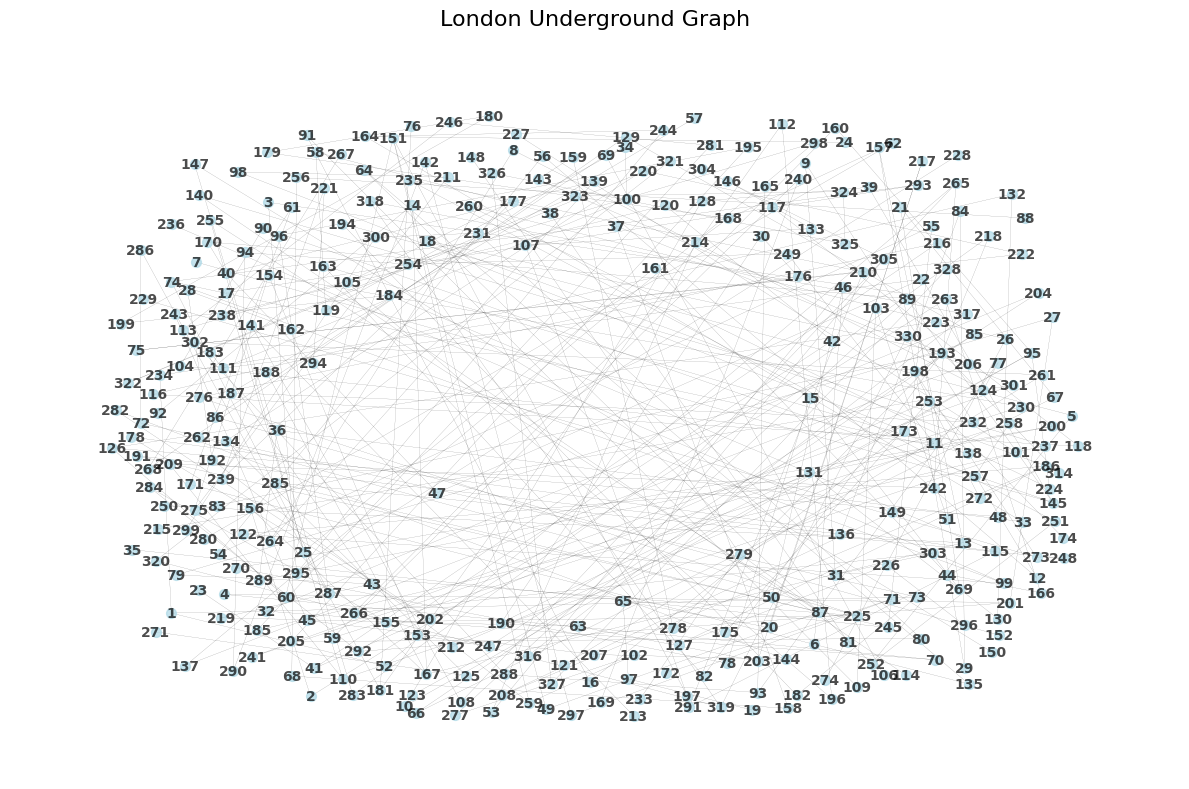

In [60]:
fig, ax = plt.subplots(figsize=(12, 8))

layout = nx.spring_layout(mst, k=1, iterations=10)

nx.draw(mst, 
        pos=layout,
        with_labels=True,
        node_color='lightblue',     # Light blue nodes
        node_size=50,               # Larger nodes
        font_size=10,               # Adjust font size
        font_weight='bold',         # Bold labels
        edge_color='black',          # Gray edges
        width=0.1,                  # Thicker edges
        alpha=0.7)                  # Some transparency

plt.title("London Underground Graph", fontsize=16, pad=20)

plt.tight_layout()

plt.show()

In [61]:
total_mst_cost = sum(nx.get_edge_attributes(mst, 'weight').values())
print(f"Total Minimum Spanning Cost using Prim (Straight-line distance): {total_mst_cost:.2f}")

Total Minimum Spanning Cost using Prim (Straight-line distance): 258.18


In [62]:
kruskal = nx.minimum_spanning_tree(G, algorithm="kruskal")
total_kruskal_cost = sum(nx.get_edge_attributes(kruskal, 'weight').values())
print(f"Total Minimum Spanning Cost using Kruskal (Straight-line distance): {total_kruskal_cost:.2f}")

Total Minimum Spanning Cost using Kruskal (Straight-line distance): 258.18


### 2. Repeat this computation, now using the length of connections provided in the data.

In [63]:
G2 = nx.Graph()

# Add edges with distances as weights
for index, row in df.iterrows():
    G2.add_edge(row['station1'], row['station2'], weight=row['distance(miles)'])


In [64]:
mst = nx.minimum_spanning_tree(G2, algorithm="prim")
total_mst_cost = sum(nx.get_edge_attributes(mst, 'weight').values())
print(f"Total Minimum Spanning Cost using Prim: {total_mst_cost:.2f}")

Total Minimum Spanning Cost using Prim: 257.44


In [65]:
mst = nx.minimum_spanning_tree(G2, algorithm="kruskal")
total_mst_cost = sum(nx.get_edge_attributes(mst, 'weight').values())
print(f"Total Minimum Spanning Cost using Kruskal: {total_mst_cost:.2f}")

Total Minimum Spanning Cost using Kruskal: 257.44


### 3. Using version 2 of the lengths, we will investigate the robustness of the computation.  We conduct 10000 experiments.  In each experiment the length of each connection is adjusted as follows:
        modified length = max{ (true length)*(1 + Gaussian(0,0.3)), 0.01*(true length) }
i.e., we modify the length randomly using a zero-norm Gaussian distribution with standard deviation 0.3 and correct if the length becomes too small.

  Plot the distribution of minimum spanning tree lengths, as well as the Value-At-Risk at level 5%.

In [66]:
np.random.seed(42)
NUM_EXPERIMENTS = 10000
mst_lengths_q3 = np.zeros(NUM_EXPERIMENTS)

def modified_length(w):
    return max(w*(1+np.random.normal(0,0.3)), 0.01*w)

for i in range(NUM_EXPERIMENTS):
    temp_g = nx.Graph()
    for index, row in df.iterrows():
        temp_g.add_edge(row['station1'], row['station2'], weight = modified_length(row['distance(miles)']))
    temp_mst = nx.minimum_spanning_tree(temp_g, algorithm = "prim")
    temp_total_mst_cost = sum(nx.get_edge_attributes(temp_mst, 'weight').values())
    mst_lengths_q3[i] = temp_total_mst_cost

In [67]:
mst_lengths_q3

array([251.84263081, 257.37588753, 262.02641129, ..., 248.80383455,
       247.06947268, 249.32337982])

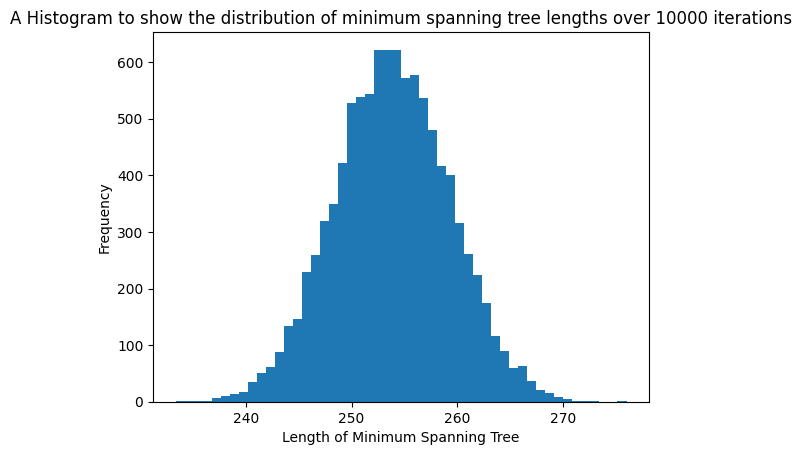

In [68]:
plt.figure()
plt.hist(mst_lengths_q3, bins = 50)
plt.xlabel("Length of Minimum Spanning Tree")
plt.ylabel("Frequency")
plt.title("A Histogram to show the distribution of minimum spanning tree lengths over 10000 iterations")
plt.show()

In [69]:
np.percentile(mst_lengths_q3, 5)

244.91585233825288

### 4. Returning to the lengths as in version 2, conduct a delete-and-repair analysis.  That is to say, for each link L of the minimum spanning tree, we

    (a) Remove L from the network.
    
    (b) Compute a minimum spanning tree for the network with L (and only L) removed.  

  Plot the resulting values for the length of the minimum spanning tree.

Note: we only remove one link at a time.

Our thought process for this question is:
1. We have already determined the minimum spanning tree in question 2.
2. We are going to loop through every edge in mst_edges_q2 and remove that edge from the network and calculate the MST again.

In [70]:
mst_edges = list(mst.edges(data=True))
mst_lengths_q4 = []

for edge in mst_edges:
    temp_edges = mst_edges.copy()
    temp_edges.remove(edge)
    temp_g = nx.Graph()

    for e in temp_edges:
        temp_g.add_edge(e[0], e[1], weight=e[2]["weight"])

    temp_mst = nx.minimum_spanning_tree(temp_g, algorithm="prim")
    temp_total_mst_cost = sum(nx.get_edge_attributes(temp_mst, 'weight').values())
    mst_lengths_q4.append(temp_total_mst_cost)

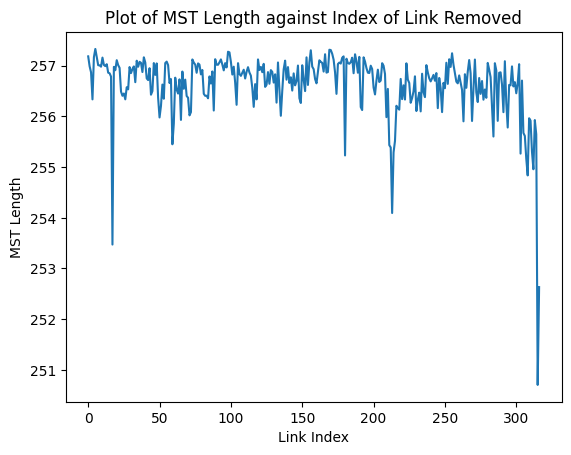

In [71]:
x = np.arange(len(mst_lengths_q4))
plt.figure()
plt.plot(x, mst_lengths_q4)
plt.title("Plot of MST Length against Index of Link Removed")
plt.xlabel("Link Index")
plt.ylabel("MST Length")
plt.show()

In [72]:
mst_edges = list(mst.edges(data=True))
mst_lengths_q4 = []

for edge in mst_edges:
    temp_g = G2.copy()
    temp_g.remove_edge(edge[0], edge[1])
    
    temp_mst = nx.minimum_spanning_tree(temp_g, algorithm="prim")
    temp_total_mst_cost = sum(nx.get_edge_attributes(temp_mst, 'weight').values())
    mst_lengths_q4.append(temp_total_mst_cost)

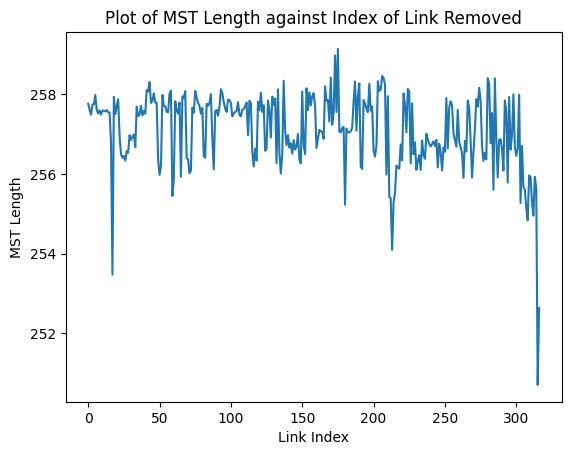

In [73]:
x = np.arange(len(mst_lengths_q4))
plt.figure()
plt.plot(x, mst_lengths_q4)
plt.title("Plot of MST Length against Index of Link Removed")
plt.xlabel("Link Index")
plt.ylabel("MST Length")
plt.show()

In [78]:
mst_edges[np.argmin(mst_lengths_q4)]

(326, 327, {'weight': 6.740020000154495})

In [79]:
np.argmin(mst_lengths_q4)

315

In [81]:
df

,station1,station2,distance(miles),st1_latitude,st1_longitude,st1_station_name,st2_latitude,st2_longitude,st2_station_name,straight_line_distance
0,11,163,0.257855,51.522600,-0.157100,Baker Street,51.522500,-0.163100,Marylebone,0.258855
1,11,212,0.454449,51.522600,-0.157100,Baker Street,51.523400,-0.146600,Regent's Park,0.456194
2,49,87,0.111148,51.508000,-0.124700,Charing Cross,51.507400,-0.122300,Embankment,0.111538
3,49,197,0.426744,51.508000,-0.124700,Charing Cross,51.509800,-0.134200,Picadilly Circus,0.428305
4,82,163,0.273407,51.519900,-0.167900,Edgware Road (B),51.522500,-0.163100,Marylebone,0.274160
...,...,...,...,...,...,...,...,...,...,...
426,324,325,1.514774,51.523393,-0.646248,Burnham,51.523419,-0.681509,Taplow,1.520650
427,325,326,1.794392,51.523419,-0.681509,Taplow,51.518538,-0.722533,Maidenhead,1.801187
428,326,327,6.740020,51.518538,-0.722533,Maidenhead,51.475462,-0.863242,Twyford,6.762726
429,327,328,4.810656,51.475462,-0.863242,Twyford,51.458688,-0.971795,Reading,4.828572
